# **Normalize and Integrate**

--------------

**Motivation:**

Biologically similar cells are not necessarily directly comparable in a dataset because of different technical biases, amongst many the different percentage of captured transcripts (capture efficiency), the presence of technical replicates, the presence of noisy transcripts. The capture efficiency can be influenced by many factors, i.e. the different transcript tags leading to different capture efficiency, the type of protocol used in the laboratory, the amount of PCR performed on different transcripts.

To avoid these differences, a normalization approach is needed. Normalization is one of the main topics of scRNAseq data preprocessing, and many advanced techniques takes into account the statistical distribution of counts and the presence of technical/biological features of interest.

The most standard approach is the TMP (Transcript Per Million) normalization followed by logarithmization and standardization. We have applied this technique to have a double-check on our data filtering. 

As a rule of thumb, TPM+log+standardization is no longer consider a very good normalization technique, especially when you are integrating multiple datasets together. Instead, it is suggested to use more advanced methods for considering technical and biological covariates as part of a statistical model for the transcripts. One of the current state-of-the-art method is scTransform. We will apply it in this notebook.

---------------------------

**Learning objectives:**
- Perform advanced normalization of multiple datasets
- Understand and apply tools for multiple datasets integration
- Evaluate the quality of data integration

----------------

**Execution time: 40 minutes** if using at least 2 cores (that is, at least 16 virtual-CPUs). Expect longer time with slower hardware, and a RAM usage of some 40-100GB.

-----------------

***Import packages***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad

plt.rcParams['figure.figsize']=(6,6) #rescale figures

We will need to use a couple of packages that are only developed in R. To do this we will use the package `rpy2`, that allows `python-R` interaction. Below we will load the package and some settings (You do not need to look at them, but they can be useful as reference for your own future coding).

**Load the two separated datasets**

In [2]:
sample_2 = sc.read('../../Data/notebooks_data/sample_2.filt.h5ad')
sample_3 = sc.read('../../Data/notebooks_data/sample_3.filt.h5ad')

## Concatenation of datasets

Here we concatenate the two datasets. We establish the name of each sample. Each cell will be assigned the correct name, that will be stored in `sample.obs['batch']`. We clean also all the variables (quantities calculated on genes), because those will be duplicated from each dataset, while observations (quantities calculated on cells) will be concatenated together without duplication.

In [3]:
batch_names = ['SAM_2','SAM_3'] #choose names for samples
sample = ad.AnnData.concatenate(sample_2, sample_3) #concatenate
sample.rename_categories(key='batch', categories=batch_names) #apply sample names
scv.utils.cleanup(sample, clean='var') #remove duplicated gene quantites

We unload the old separated samples to free memory

In [4]:
del sample_2, sample_3

The new sample looks like this. It has the well-known observations from the previous coding sessions and has all the stored matrices. We have now more than 6000 cells.

In [5]:
sample

AnnData object with n_obs × n_vars = 7591 × 23040
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_rp', 'perc_mito', 'SDO_outliers', 'SDO_outlyingness', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch'
    layers: 'umi_raw'

For each sample, we filtered away genes shown in less than 10 cells. Now we have two samples, so it is good to filter away genes shown in less than 20 cells (to be sure that a sample does not have genes that are absent in the other sample)

In [6]:
sc.preprocessing.filter_genes(sample, min_cells=20)

This should eliminate a few more genes

In [7]:
sample

AnnData object with n_obs × n_vars = 7591 × 23012
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_rp', 'perc_mito', 'SDO_outliers', 'SDO_outlyingness', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch'
    var: 'n_cells'
    layers: 'umi_raw'

## Normalization

We will normalize the dataset by using a more advanced tool. While standard normalization seemed to work fine previously, the result is still very much influenced by technical factors, such as by 
- how cell transcripts have been captured efficiently prior to sequencing
- difference in PCR amplification
We will use a tool called `sctransform`: this does a statistical model for the transcript counts and does a regression to remove technical factors connected to the amount of transcripts and stabilize the variance of the data. In this way we will have a normalized dataset that is better explained by biological processes rather than technical variables.

In [67]:
help(sc.pp.combat)

Help on function combat in module scanpy.preprocessing._combat:

combat(adata: anndata._core.anndata.AnnData, key: str = 'batch', covariates: Union[Collection[str], NoneType] = None, inplace: bool = True) -> Union[anndata._core.anndata.AnnData, numpy.ndarray, NoneType]
    ComBat function for batch effect correction [Johnson07]_ [Leek12]_
    [Pedersen12]_.
    
    Corrects for batch effects by fitting linear models, gains statistical power
    via an EB framework where information is borrowed across genes.
    This uses the implementation `combat.py`_ [Pedersen12]_.
    
    .. _combat.py: https://github.com/brentp/combat.py
    
    Parameters
    ----------
    adata
        Annotated data matrix
    key
        Key to a categorical annotation from :attr:`~anndata.AnnData.obs`
        that will be used for batch effect removal.
    covariates
        Additional covariates besides the batch variable such as adjustment
        variables or biological condition. This parameter refers 

In [68]:
sc.pp.combat( sample )

We store in `.layers` the normalized and UMI matrix

In [69]:
sample.layers['normalized'] = sample.X.copy()

## Data integration

### Standard PCA framework

Let's now calculate and plot the PCA using normalized data. We can see that the PCA of the two samples is not perfectly overlapping. This is because PCA does not model in any way the presence of two different samples. Even though this has been taken into account during normalization, it is not enough to integrate the datasets together.

In [70]:
sample.X = sample.layers['normalized'].copy() #use normalized data in .X
#sc.pp.scale(sample) #standardize
sc.preprocessing.pca(sample, svd_solver='arpack', random_state=12345) #do PCA

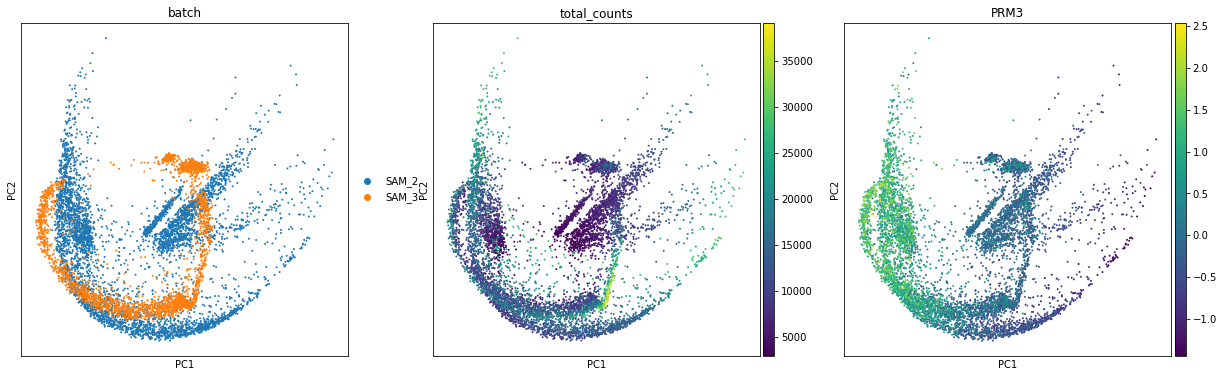

In [71]:
sc.pl.pca(sample, color=['batch','total_counts','PRM3'])

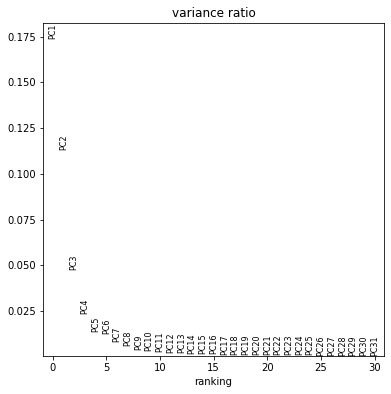

In [72]:
sc.pl.pca_variance_ratio(sample)

One can keep the PCA above and compensate for differences between batches when calculating the neighborhood of each cell (the distance between cells that are most similar). This is done by taking into account the presence of multiple samples with the package `bbknn` (in the filtering notebooks we used the command `sc.pp.neighbors`)

In [73]:
import bbknn as bbknn
bbknn.bbknn(sample, n_pcs=15) 

We can visualize the result with an UMAP plot. We can see how the samples are now overlapping in the plot.

In [74]:
sc.tools.umap(sample, random_state=54321)

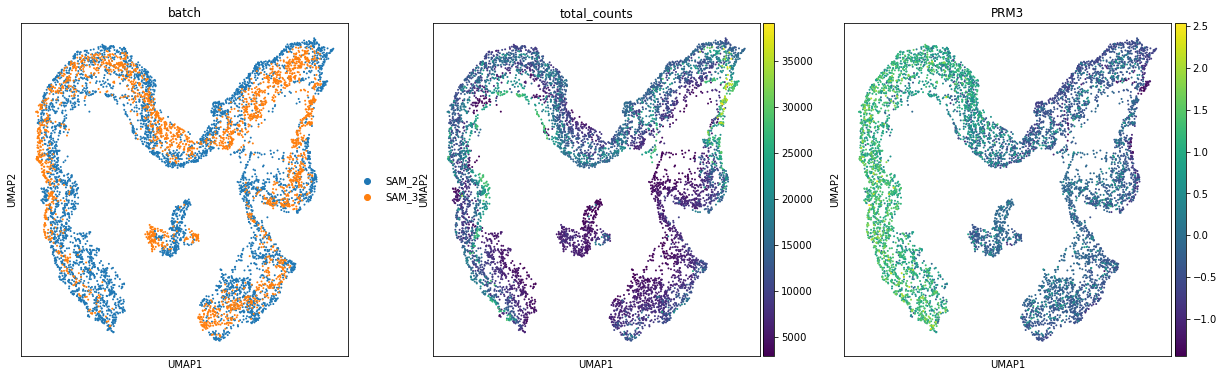

In [75]:
sc.plotting.umap(sample, color=['batch','total_counts','PRM3'])

In [27]:
sample = sc.read('../../Data/notebooks_data/sample_123.filt.norm.h5ad')

Only considering the two last: ['.norm', '.h5ad'].
Only considering the two last: ['.norm', '.h5ad'].


### Generalized PCA model

A better way of doing a PCA for multiple samples is to use a model that takes into account the various batches. We can do this with the package `glmpca`. The execution time can be a bit longer (especially if you choose many variable genes in the normalization), but the resulting PCA is usually better thanks to a statistical model better reflectiong the transcript distribution.

We first need to model the batch variables to be compatible in `glmpca`

In [76]:
import sklearn.preprocessing
import numpy as np
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(sample.obs['batch'])
batch_onehot = label_binarizer.transform(sample.obs['batch'])

We then set a random seed to have a reproducible generalized PCA

In [77]:
np.random.seed(12345)

We run `glmpca`. If the algorithm fails, you need to change the parameter `penalty` of the command `glmpca.glmpca`. Always start from 1 and increase by ten if errors occur. In case you keep getting error, then you need to resort to the standard PCA used before. That happens when some transcripts have a very noisy distribution, for example because of bad data filtering in the early steps of the analysis. In our case we made the algorithm work with `penalty=10`. Note in the second line how we subset the dataset to use only the highly variable genes. Also, we use the matrix of corrected UMI counts as a base for the PCA (third line)

In [105]:
sc.pp.highly_variable_genes(sample, n_top_genes=15000)

In [106]:
sample

AnnData object with n_obs × n_vars = 7591 × 23012
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_rp', 'perc_mito', 'SDO_outliers', 'SDO_outlyingness', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'batch_colors', 'neighbors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'umi_raw', 'normalized'
    obsp: 'distances', 'connectivities'

In [107]:
batch_onehot

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
ctl = {"maxIter":10, "eps":1e-3, "optimizeTheta":True}
sample_glmpca = sample.copy()#[:,sample.var['highly_variable']].copy()
Y = sample_glmpca.layers['umi_raw'].T.copy()
Y = np.asarray(Y)
from glmpca import glmpca
print("calculating")
res = glmpca.glmpca(Y, 15, penalty=1000, X=batch_onehot, verbose=True, ctl=ctl)
factors = res["factors"]
sample_glmpca.obsm['X_pca_new']=factors

calculating
Iteration: 0 | deviance=1.5288E+8
Iteration: 1 | deviance=1.4877E+8
Iteration: 2 | deviance=1.3991E+8
Iteration: 3 | deviance=1.2282E+8


In [ ]:
sample_glmpca.obsm['X_pca_old'] =  sample_glmpca.obsm['X_pca'].copy()
sample_glmpca.obsm['X_pca'] =  sample_glmpca.obsm['X_pca_new'].copy()

Plot the new PCA on the subsetted dataset. The integration looks of higher quality than before.

In [ ]:
sc.pl.pca(sample_glmpca, color=['batch'])

Assign the new PCA to the full dataset

In [ ]:
sample.obsm['X_pca'] = sample_glmpca.obsm['X_pca'].copy()

Recalculate and plot the UMAP

In [ ]:
import bbknn as bbknn
bbknn.bbknn(sample)
sc.tools.umap(sample, random_state=54321)
sc.plotting.umap(sample, color=['batch','total_counts','PRM3'])

In [34]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.h5ad')

## Evaluate the integration

We can double check if the integration is still acceptable. At least in terms of overlapping, the previous version was slightly better, but in general it is a good practice to use the `glmpca` approach if this does not fail furing execution

In [35]:
data = np.array( sample.obsm['X_umap'] )
batch = np.array( sample.obs['batch'] )

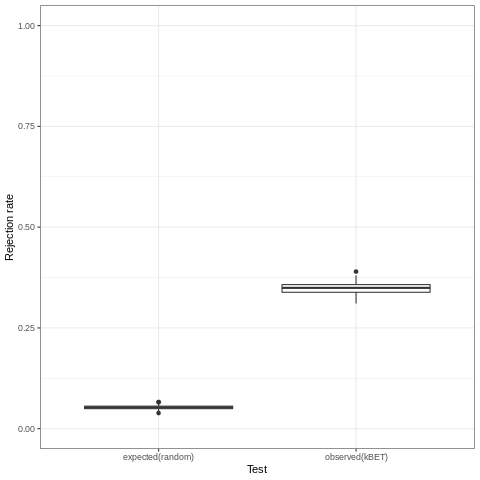

In [36]:
%%R -i batch -i data

library(kBET)
library(ggplot2)

batch.estimate <- kBET( data, batch, plot=TRUE, k0=10 )
plot.data <- data.frame(class=rep(c('observed', 'expected'), 
                                  each=length(batch.estimate$stats$kBET.observed)), 
                        data =  c(batch.estimate$stats$kBET.observed,
                                  batch.estimate$stats$kBET.expected))

**How would a missing integration step look like?**

We can see the evaluation of an integration without using the proper normalization and integration steps with PCA and neighborhoods calculations.

In [37]:
sample.X = sample.layers['umi_raw'].copy()
sc.pp.log1p(sample)
sc.pp.normalize_total(sample)
sc.pp.scale(sample)
sc.pp.pca(sample, svd_solver='arpack', random_state=12345)
sc.pp.neighbors(sample, random_state=12345)
sc.tools.umap(sample, random_state=54321, n_components=2)

The UMAP plot speaks pretty clearly

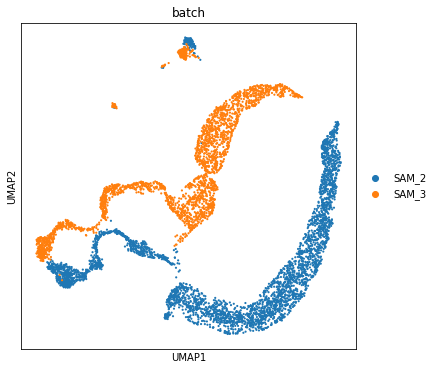

In [38]:
sc.pl.umap(sample, color=['batch'])

The overlapping test gets naturally a high rejection

In [39]:
non_integrated_data = np.array( sample.obsm['X_umap'] )
batch = np.array( sample.obs['batch'] )

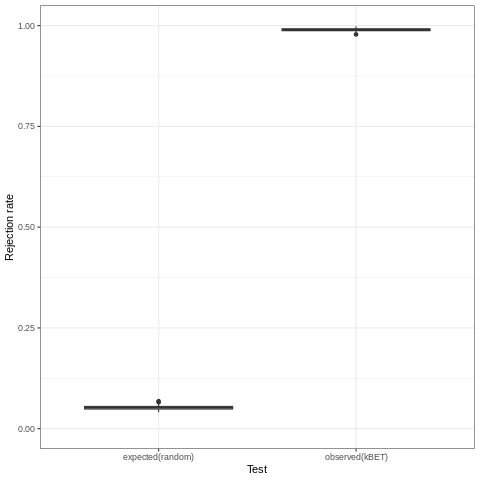

In [40]:
%%R -i batch -i non_integrated_data

library(kBET)
library(ggplot2)

batch.estimate <- kBET( non_integrated_data, batch, plot=TRUE, k0=10 )
plot.data <- data.frame(class=rep(c('observed', 'expected'), 
                                  each=length(batch.estimate$stats$kBET.observed)), 
                        data =  c(batch.estimate$stats$kBET.observed,
                                  batch.estimate$stats$kBET.expected))

## Wrapping up

This notebook completes the integration of the datasets. We have both used the standard PCA and then a version of the PCA that can model transcript distribution and takes batches into account. Finally we have calculated cell neighborhoods with `bbknn`: this allows us to further remove the technical differences between batches. We used a statistical test to check that the integration has been successful, and compared it with the test performed on a dataset without integration steps.